In [1]:
import csv
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D,MaxPooling2D
import sklearn
from sklearn.model_selection import train_test_split
import random as rand
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback


Using TensorFlow backend.


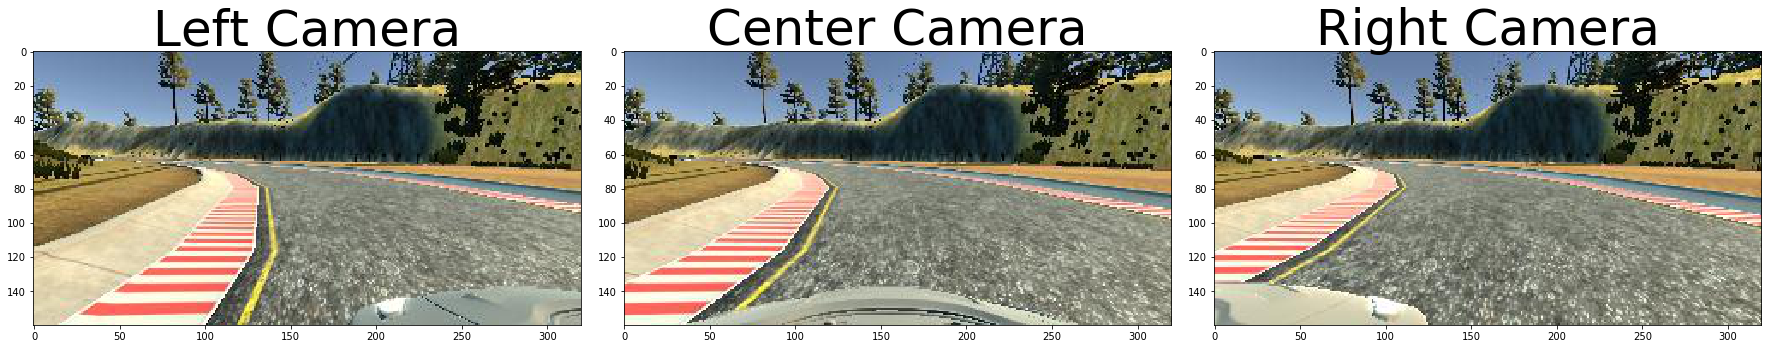

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
center_img = mpimg.imread('data/IMG/center_2017_05_15_19_34_10_839.jpg')
left_img = mpimg.imread('data/IMG/left_2017_05_15_19_34_10_839.jpg')
right_img = mpimg.imread('data/IMG/right_2017_05_15_19_34_10_839.jpg')
#plt.imshow(img)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(left_img)
ax1.set_title('Left Camera', fontsize=50)
ax2.imshow(center_img)
ax2.set_title('Center Camera', fontsize=50)
ax3.imshow(right_img)
ax3.set_title('Right Camera', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

In [3]:
#Correction that later will be applied to Left and Right Camera Measurement Values
correction=0.2
epoches=3
batch_size=32

#Empty array for storing csv data
lines=[]

#From lesson 7
#UDACITY TRAINING DATA
#with open('data/driving_log.csv') as csvfile:
#    reader =csv.reader(csvfile)
#    for line in reader:
#        lines.append(line)

#Own data driving forward 2 clean laps
with open('data/driving_log_long.csv') as csvfile:
    reader =csv.reader(csvfile)
    for line in reader:
        lines.append(line)

        
#Own data driving forward
#with open('data/driving_log_recoveries.csv') as csvfile:
#    reader =csv.reader(csvfile)
#    for line in reader:
#        lines.append(line)
        
        
        
#Own data driving forward and reverse            
#with open('data/driving_log_reverse.csv') as csvfile:
#    reader =csv.reader(csvfile)
#    for line in reader:
#        lines.append(line)
            
    
# Each line has 3 images(center, left and right) and each image also will have a flip so
# number of lines*6 is total number of images
print('Number of Lines',len(lines))
print('Total Number of images:',6*len(lines))

#Saving 20% of images as test images
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

#Generator based on Behnamprime's https://github.com/behnamprime/UDACITY-CarND-Behavioral-Cloning-P3
def generator(lines, batch_size=batch_size):
    num_samples = len(lines)
    while 1: # Loop forever so the generator never terminates
        rand.shuffle(lines)
        for offset in range(0, num_samples, batch_size):
            batch_samples = lines[offset:offset+batch_size]
            images=[]
            measurements=[]
            for line in batch_samples:
                measurement=float(line[3])
                #Invert steering angle with flipping image lesson 11
                flipped_measurement=(measurement)*-1.0
                for i in range(0,3):
                   source_path=line[i]
                   image=cv2.imread('data/'+source_path)
                   #CONVERT FROM BGR TO RGB... otherwise nothing works!!!!!! 
                   image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                   images.append(image)
                   #Flipping image and measurement and adding correction
                   flipped_image=cv2.flip(image,1)
                   images.append(flipped_image)
                   
                   #center image
                   if i==0:
                      measurements.append(measurement)
                      measurements.append(flipped_measurement)
                   
                   #left image data correction and augmentation lesson 12 
                   elif i==1:
                      measurements.append(measurement+correction)
                      #flipping the image should flip the correction
                      measurements.append(flipped_measurement-correction)
                        
                   #right image left image data correction and augmentation lesson 12     
                   else:
                      measurements.append(measurement-correction)
                      #flipping the image should flip the correction
                      measurements.append(flipped_measurement+correction)
            
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)


train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)




Number of Lines 2372
Total Number of images: 14232


In [5]:
#Comma.ai driving neural network from https://github.com/commaai/research/blob/master/train_steering_model.py implementation from George Sung https://github.com/georgesung/behavioral_cloning 

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(160, 320, 3),
        output_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))
model.add(Convolution2D(16, 8, 8, input_shape=(64, 64, 3), subsample=(4, 4), border_mode="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 23, 80, 16)    3088        cropping2d_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 11, 40, 16)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
#Training The Model,20% of Data is Allocated for Validation
#It is important to notice that there are 6 images per line is read in generator, so in the
# fit_generator we must consider 6*len(train_samples) as total number of samples
history_object = model.fit_generator(train_generator, samples_per_epoch= 6*len(train_samples), validation_data=validation_generator,
            nb_val_samples=6*len(validation_samples), nb_epoch=epoches, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True

)])


#Saving The Model
model.save('commai.h5')

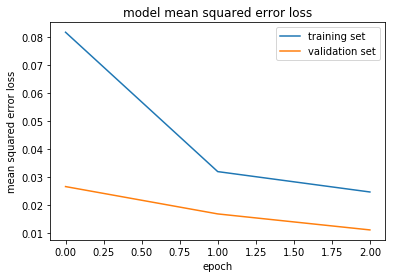

In [7]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [4]:
#NVIDIA Model
model=Sequential()
#Adding normalization and cropping layers
model.add(Lambda(lambda x:x/255.0-0.5,input_shape=(160,320,3)))
#From lesson 17
model.add(Cropping2D(cropping=((50,20),(0,0))))
#Main model
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [5]:
with open('model.json', 'w') as file:
    file.write(model.to_json())


In [13]:
#Training The Model,20% of Data is Allocated for Validation
#It is important to notice that there are 6 images per line is read in generator, so in the
# fit_generator we must consider 6*len(train_samples) as total number of samples
history_object = model.fit_generator(train_generator, samples_per_epoch= 6*len(train_samples), validation_data=validation_generator,
            nb_val_samples=6*len(validation_samples), nb_epoch=epoches, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True

)])


#Saving The Model
model.save('NVIDIA.h5')

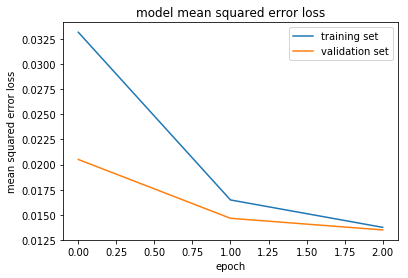

In [14]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()